In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt 

from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import LeakyReLU

In [2]:
Autoencoder = tf.keras.models.load_model('TAE_z3_best_model', compile=False)

In [3]:
phis=[0.93,1.0,1.10] 
Ts=[1160,1200,1130]

name_11='State_space_cte_pressure_T' 
name_12='_phi_'
name_21='Reaction_rates_cte_pressure_T'
name_22='_phi_'

end='.csv'

In [4]:
def hydrogen_data_clean_shift_sandiego_cantera(cantera_species,cantera_sources,maximum_values):
    cantera_sources=cantera_sources.add_suffix('w')
    cantera_sources=cantera_sources.iloc[:,1:] #for taking out the timestep as data 
    
    cantera_time=cantera_species.iloc[:,1]
    cantera_temperature=cantera_species.iloc[:,2]
    cantera_pressure=cantera_species.iloc[:,3]
    
    cantera_species_fractions=cantera_species.iloc[:,4:12]
    
    n_columns_mass_fraction=np.shape(cantera_species_fractions)[1]
    
    cantera_sources=cantera_sources.loc[:,(cantera_sources!=0).any(axis=0)]
    cantera_sources=cantera_sources.loc[:, (cantera_sources != cantera_sources.iloc[0]).any()]
    
    n_columns_source=np.shape(cantera_sources)[1]
    
    cantera_data=pd.concat([cantera_time, cantera_temperature,cantera_species_fractions,cantera_sources],axis=1)

    maximum_values=maximum_values.iloc[0,1:]
    maximum_values=maximum_values.to_numpy()
    
    iterations=np.shape(cantera_data)[1]
    
    #cantera_data.divide(maximum_values)
    for j in range(iterations):
        cantera_data.iloc[:,j]=cantera_data.iloc[:,j]/(maximum_values[j])
    
    cantera_data_shift=cantera_data.loc[1:,:]
    cantera_data_shift=cantera_data_shift.add_suffix('shift')
    
    cantera_data=cantera_data.reset_index()
    cantera_data_shift=cantera_data_shift.reset_index()
    
    cantera_data=cantera_data.iloc[:,1:]
    cantera_data_shift=cantera_data_shift.iloc[:,1:]

    cantera_data=cantera_data.iloc[0:(np.shape(cantera_data_shift)[0]),:]
    
    data_all=pd.concat([cantera_data, cantera_data_shift], axis=1)

    columns=data_all.columns.to_list()
    
    return data_all, n_columns_source, n_columns_mass_fraction, columns

In [5]:
k=1
cantera_species=pd.read_csv(name_11+str(Ts[k])+name_12+str(phis[k])+end)
cantera_species=pd.DataFrame(cantera_species)

cantera_sources=pd.read_csv(name_21+str(Ts[k])+name_22+str(phis[k])+end)
cantera_sources=pd.DataFrame(cantera_sources)

maximum_values=pd.read_csv('maximum_values_Phi_T_Sampling.csv')
maximum_values=pd.DataFrame(maximum_values)

In [6]:
dataset, n_columns_source, n_columns_mass_fraction, columns=hydrogen_data_clean_shift_sandiego_cantera(cantera_species,cantera_sources,maximum_values)

In [7]:
latent_space=Autoencoder.lat_activation(Autoencoder.encoder(dataset.iloc[:,1:2+n_columns_mass_fraction].to_numpy())).numpy()

In [8]:
Z_gradient=np.zeros_like(latent_space)
time_data=cantera_species.loc[1:,'t[s]']
time_step=time_data[1]/2
print(np.shape(Z_gradient))
print(np.shape(time_data))
print(time_step)

(4999, 3)
(4999,)
1e-07


In [9]:
for i in range(np.shape(latent_space)[1]):
    Z_gradient[:,i]=np.gradient(latent_space[:,i],time_step)   

In [10]:
inputs=pd.DataFrame(latent_space)
regression_outputs=pd.DataFrame(Z_gradient)

In [11]:
inputs_s=inputs**2
inputs_c=inputs**3
inputs_q=inputs**4
inputs_sq=inputs**5
regression_inputs=inputs

for j in range(np.shape(inputs)[1]):
    for k in range(np.shape(inputs)[1]):
        inputs_ss=inputs.iloc[:,k]*inputs.iloc[:,j]
        inputs_cc=inputs_s.iloc[:,k]*inputs.iloc[:,j]
        inputs_qq=inputs_c.iloc[:,k]*inputs.iloc[:,j]
        inputs_qc=inputs_q.iloc[:,k]*inputs.iloc[:,j]
        inputs_sc=inputs_sq.iloc[:,k]*inputs.iloc[:,j]
        print(np.shape(inputs_ss))
        regression_inputs=pd.concat([regression_inputs, inputs_ss, inputs_cc,inputs_qq,inputs_qc,inputs_sc],axis=1)

print(np.shape(regression_inputs))
    
    

(4999,)
(4999,)
(4999,)
(4999,)
(4999,)
(4999,)
(4999,)
(4999,)
(4999,)
(4999, 48)


In [12]:
regression_inputs_all=pd.concat([regression_inputs],axis=1)
regression_inputs_all

,0,1,2,0,0,0,0,0,0,1,...,0,1,2,3,4,2,2,2,2,2
0,0.013239,0.014683,0.083971,0.000175,0.000002,3.072114e-08,4.067211e-10,5.384632e-12,0.000194,0.000003,...,0.001233,0.000018,2.658040e-07,3.902766e-09,5.730380e-11,0.007051,0.000592,0.000050,0.000004,3.505680e-07
1,0.013240,0.014683,0.083970,0.000175,0.000002,3.072507e-08,4.067860e-10,5.385664e-12,0.000194,0.000003,...,0.001233,0.000018,2.658138e-07,3.902970e-09,5.730769e-11,0.007051,0.000592,0.000050,0.000004,3.505482e-07
2,0.013240,0.014683,0.083969,0.000175,0.000002,3.072889e-08,4.068493e-10,5.386669e-12,0.000194,0.000003,...,0.001233,0.000018,2.658232e-07,3.903167e-09,5.731143e-11,0.007051,0.000592,0.000050,0.000004,3.505275e-07
3,0.013240,0.014684,0.083968,0.000175,0.000002,3.073270e-08,4.069124e-10,5.387671e-12,0.000194,0.000003,...,0.001233,0.000018,2.658320e-07,3.903351e-09,5.731494e-11,0.007051,0.000592,0.000050,0.000004,3.505081e-07
4,0.013241,0.014684,0.083968,0.000175,0.000002,3.073659e-08,4.069768e-10,5.388695e-12,0.000194,0.000003,...,0.001233,0.000018,2.658414e-07,3.903548e-09,5.731870e-11,0.007051,0.000592,0.000050,0.000004,3.504880e-07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4994,0.407057,0.339965,0.457499,0.165696,0.067448,2.745503e-02,1.117577e-02,4.549177e-03,0.138385,0.047046,...,0.155534,0.052876,1.797602e-02,6.111223e-03,2.077603e-03,0.209305,0.095757,0.043809,0.020042,9.169381e-03
4995,0.407057,0.339965,0.457499,0.165696,0.067448,2.745503e-02,1.117577e-02,4.549177e-03,0.138385,0.047046,...,0.155534,0.052876,1.797602e-02,6.111223e-03,2.077603e-03,0.209305,0.095757,0.043809,0.020042,9.169381e-03
4996,0.407057,0.339965,0.457499,0.165696,0.067448,2.745503e-02,1.117577e-02,4.549177e-03,0.138385,0.047046,...,0.155534,0.052876,1.797602e-02,6.111223e-03,2.077603e-03,0.209305,0.095757,0.043809,0.020042,9.169381e-03
4997,0.407057,0.339965,0.457499,0.165696,0.067448,2.745503e-02,1.117577e-02,4.549177e-03,0.138385,0.047046,...,0.155534,0.052876,1.797602e-02,6.111223e-03,2.077603e-03,0.209305,0.095757,0.043809,0.020042,9.169381e-03


In [13]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(regression_inputs_all, regression_outputs, test_size=0.1, random_state=42)

#out_columns=Inputs.columns.to_list()

In [14]:
from sklearn.linear_model import LinearRegression

iterations=np.shape(regression_outputs)[1]
inputs=np.shape(regression_inputs_all)[1]

coefficients=np.zeros((iterations,inputs))
intercepts=np.zeros((iterations))
scores=np.zeros((iterations))

In [15]:
from sklearn.model_selection import RepeatedKFold

n_split=5
n_repeats=3

for k in range(iterations):

    for train_index,test_index in RepeatedKFold(n_splits=n_split, n_repeats=n_repeats,random_state=42).split(X_train):
    
        x_train,x_test=X_train.iloc[train_index],X_train.iloc[test_index]
        Y_train,Y_test=y_train.iloc[train_index],y_train.iloc[test_index]
    
        reg = LinearRegression().fit(x_train, Y_train.iloc[:,k])
        
        score=reg.score(x_train, Y_train.iloc[:,k])
        scores[k]=score
        
        coeff=reg.coef_
        coefficients[k,:]=coeff
        
        intercept=reg.intercept_
        intercepts[k]= intercept

In [16]:
scores

array([0.99149972, 0.86841296, 0.87171939])

In [17]:
latent_space_check=Autoencoder.lat_activation(Autoencoder.encoder(dataset.iloc[:,1:2+n_columns_mass_fraction].to_numpy())).numpy()

In [18]:
check_inputs=pd.DataFrame(latent_space_check)

In [19]:
check_inputs_s=check_inputs**2
check_inputs_c=check_inputs**3
check_inputs_q=check_inputs**4
check_inputs_sq=check_inputs**5
check_inputs=check_inputs

for j in range(np.shape(latent_space_check)[1]):
    for k in range(np.shape(latent_space_check)[1]):
        inputs_ss=check_inputs.iloc[:,k]*check_inputs.iloc[:,j]
        inputs_cc=check_inputs_s.iloc[:,k]*check_inputs.iloc[:,j]
        inputs_qq=check_inputs_c.iloc[:,k]*check_inputs.iloc[:,j]
        inputs_qc=check_inputs_q.iloc[:,k]*check_inputs.iloc[:,j]
        inputs_sc=check_inputs_sq.iloc[:,k]*check_inputs.iloc[:,j]
        print(np.shape(inputs_ss))
        check_inputs=pd.concat([check_inputs, inputs_ss, inputs_cc, inputs_qq,inputs_qc,inputs_sc],axis=1)

(4999,)
(4999,)
(4999,)
(4999,)
(4999,)
(4999,)
(4999,)
(4999,)
(4999,)


In [20]:
print(np.shape(check_inputs))

(4999, 48)


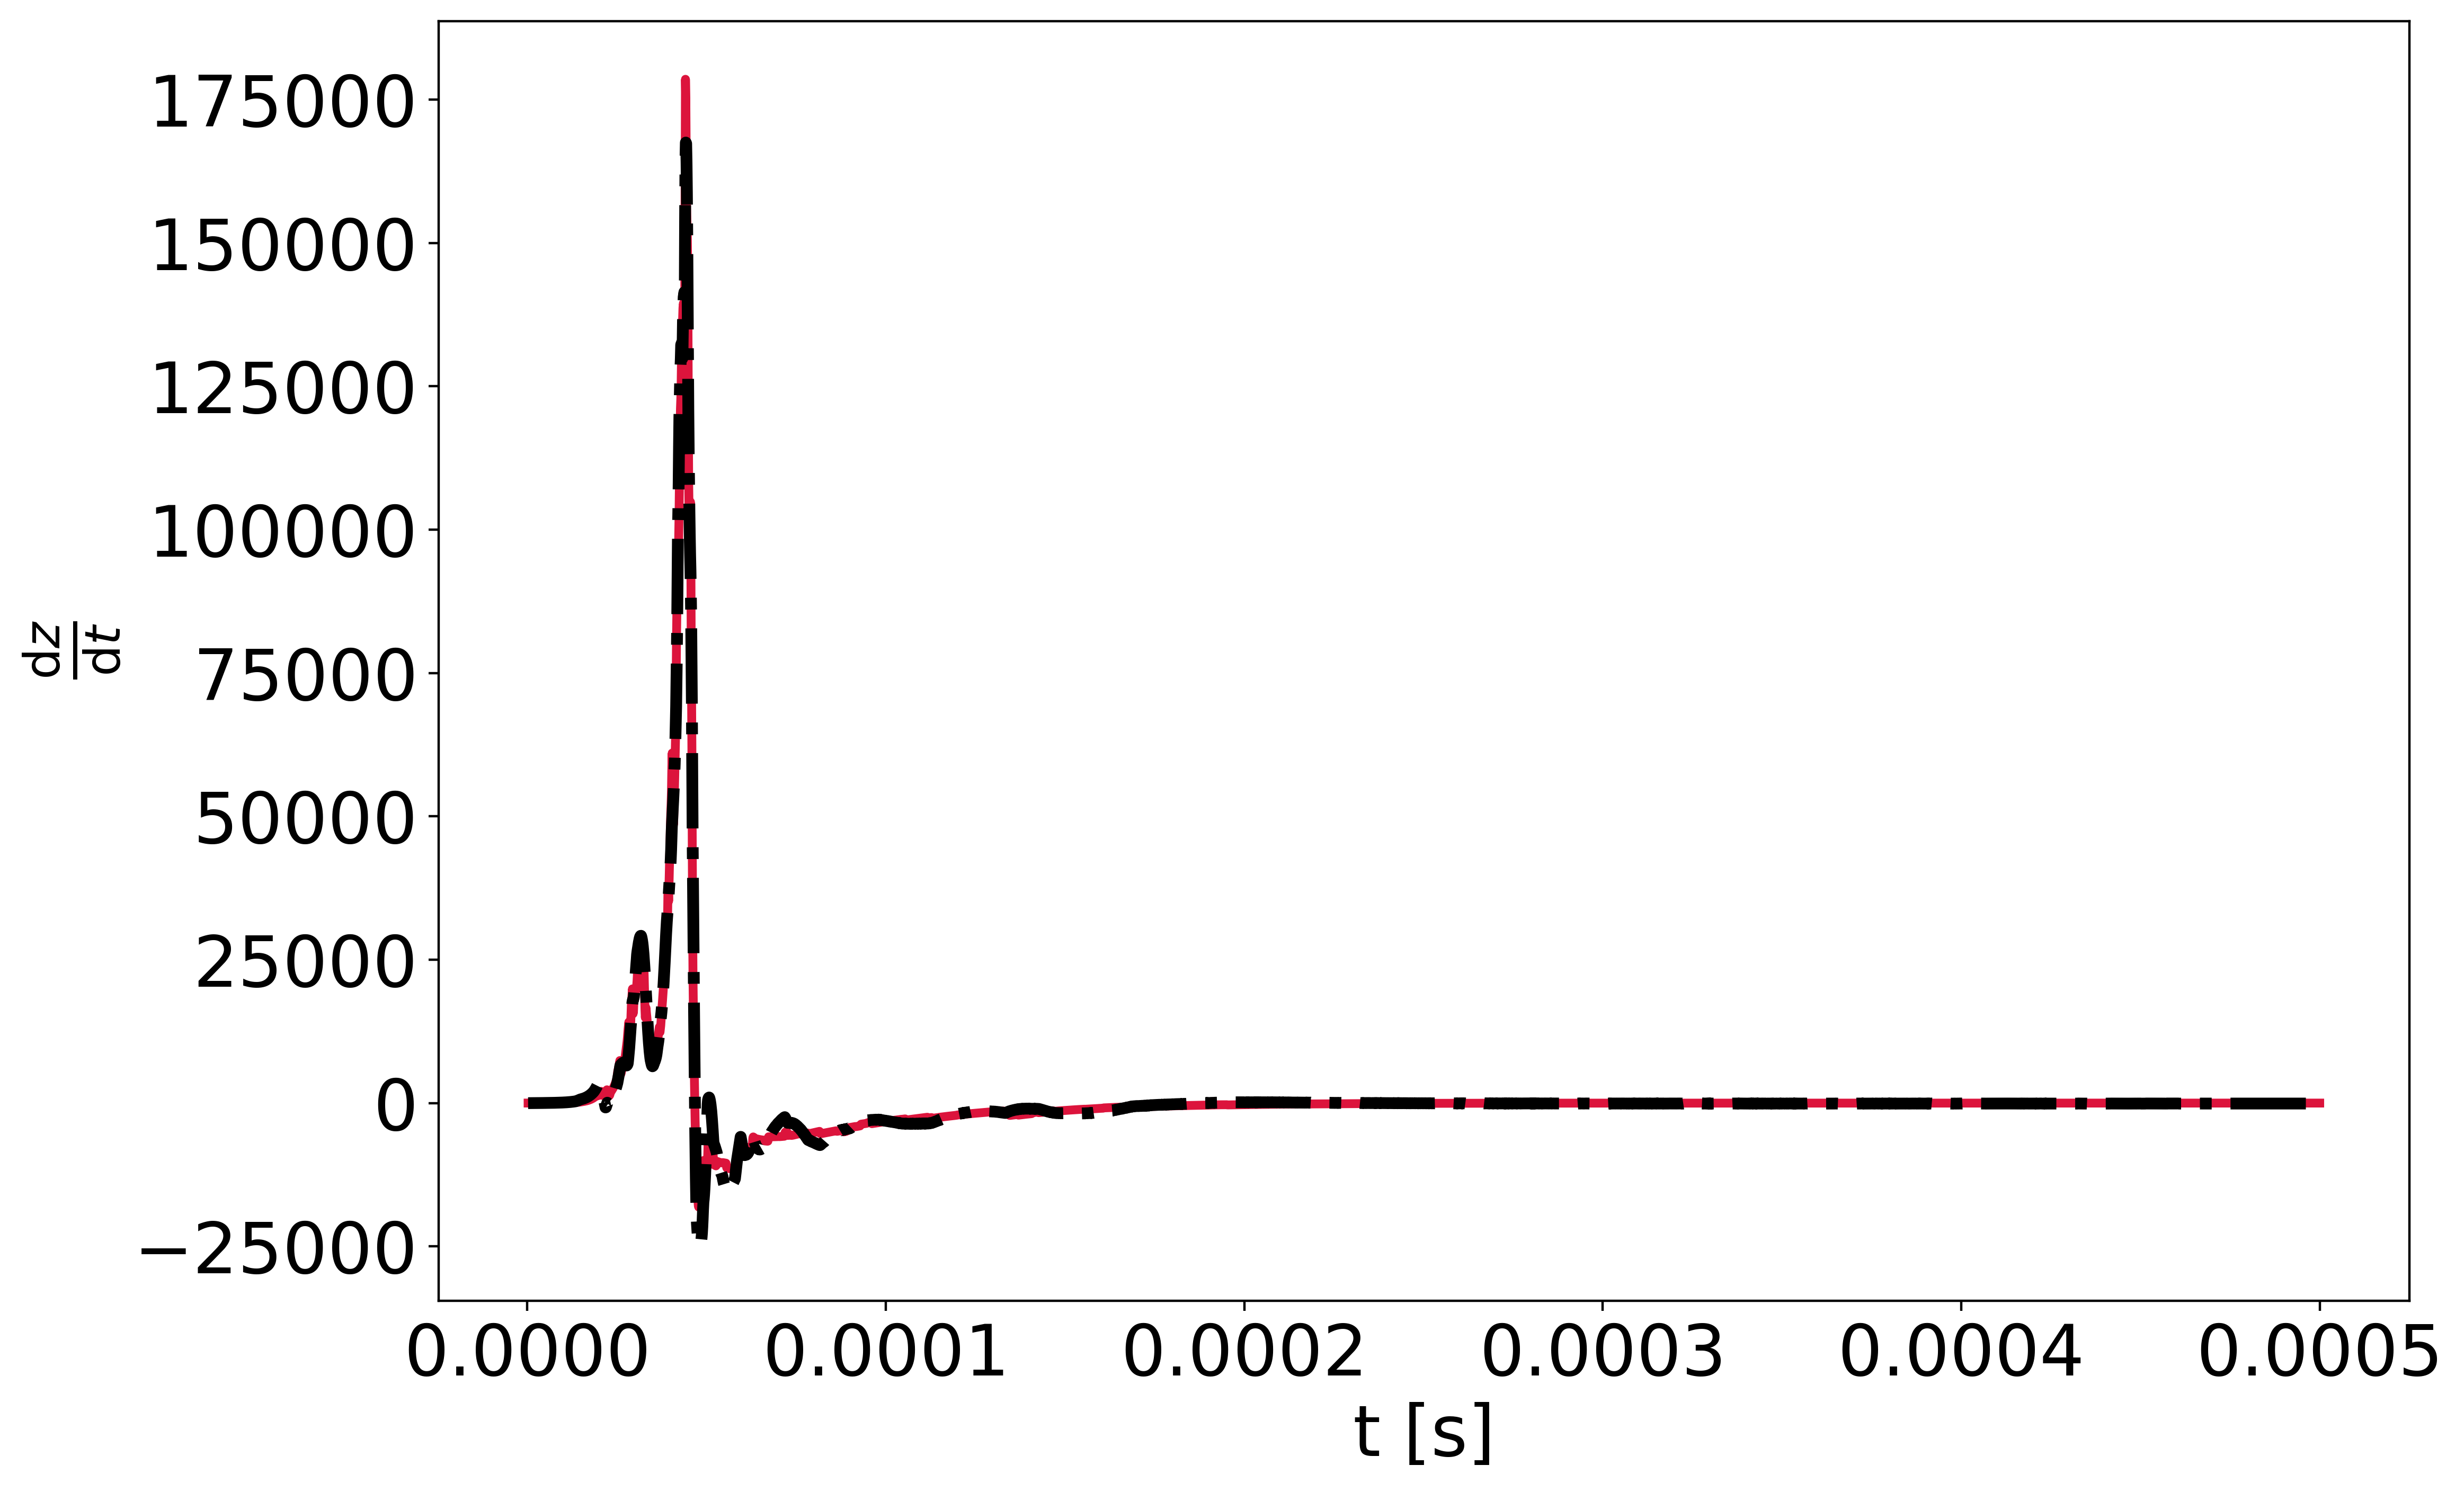

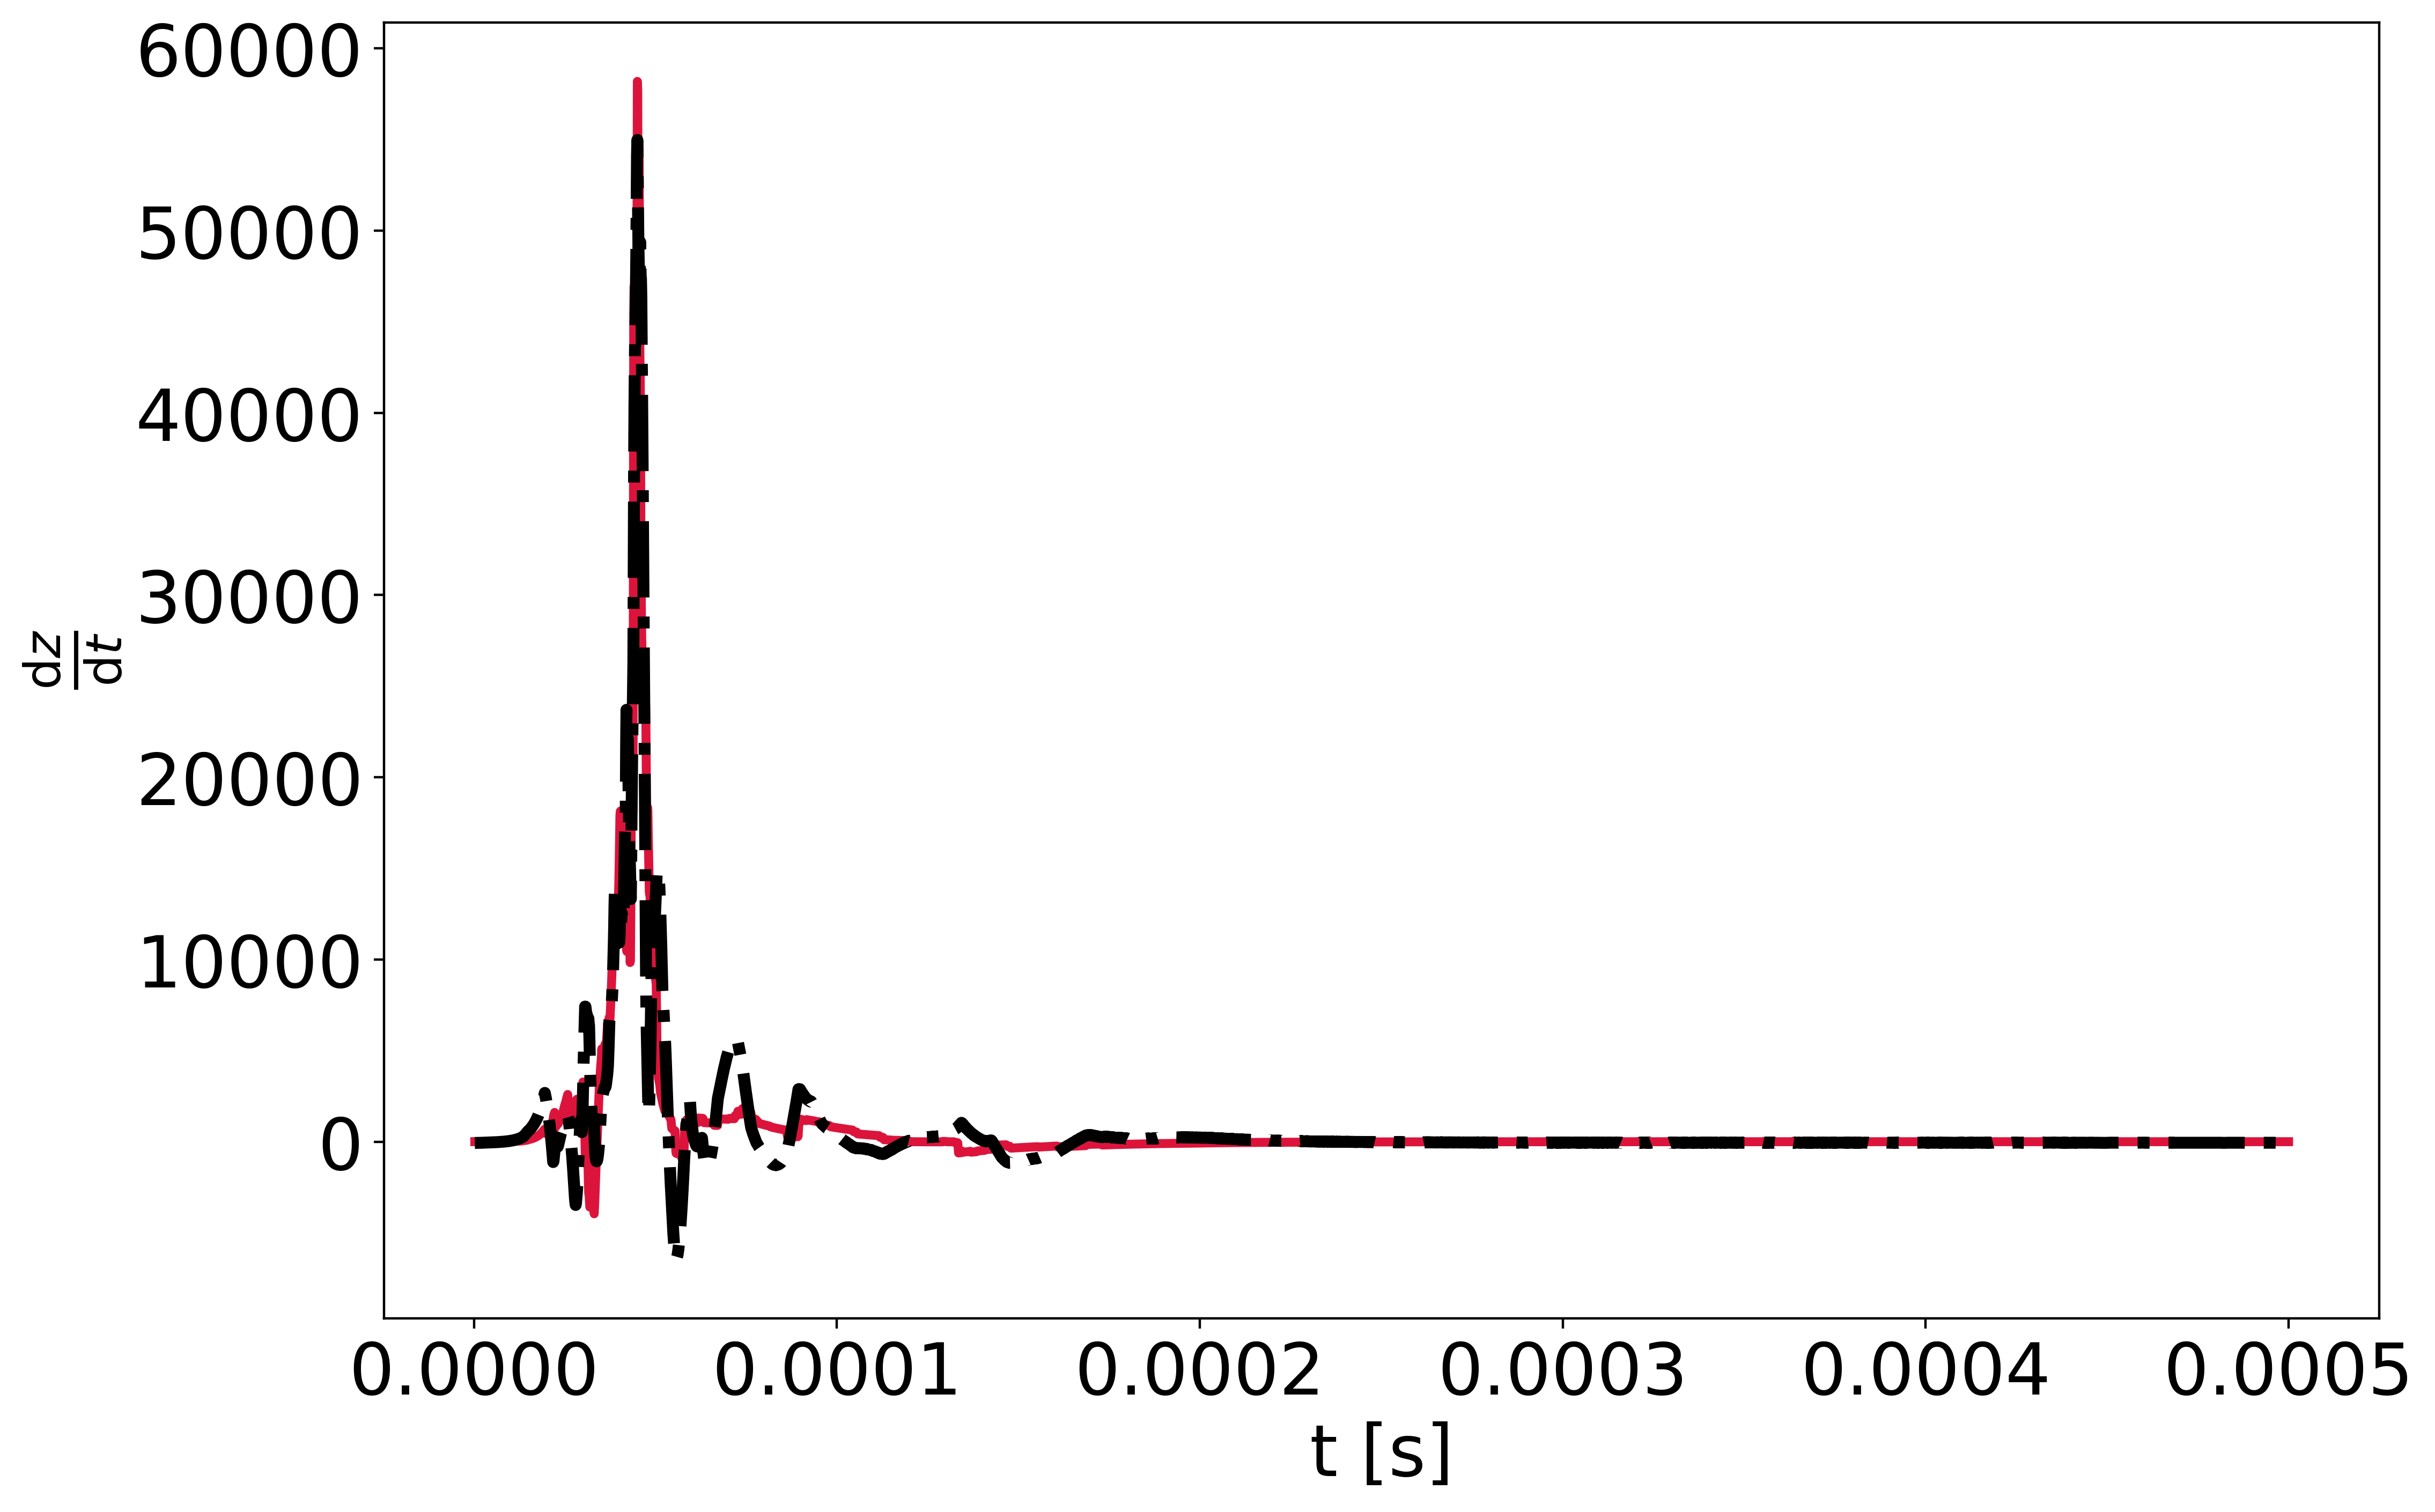

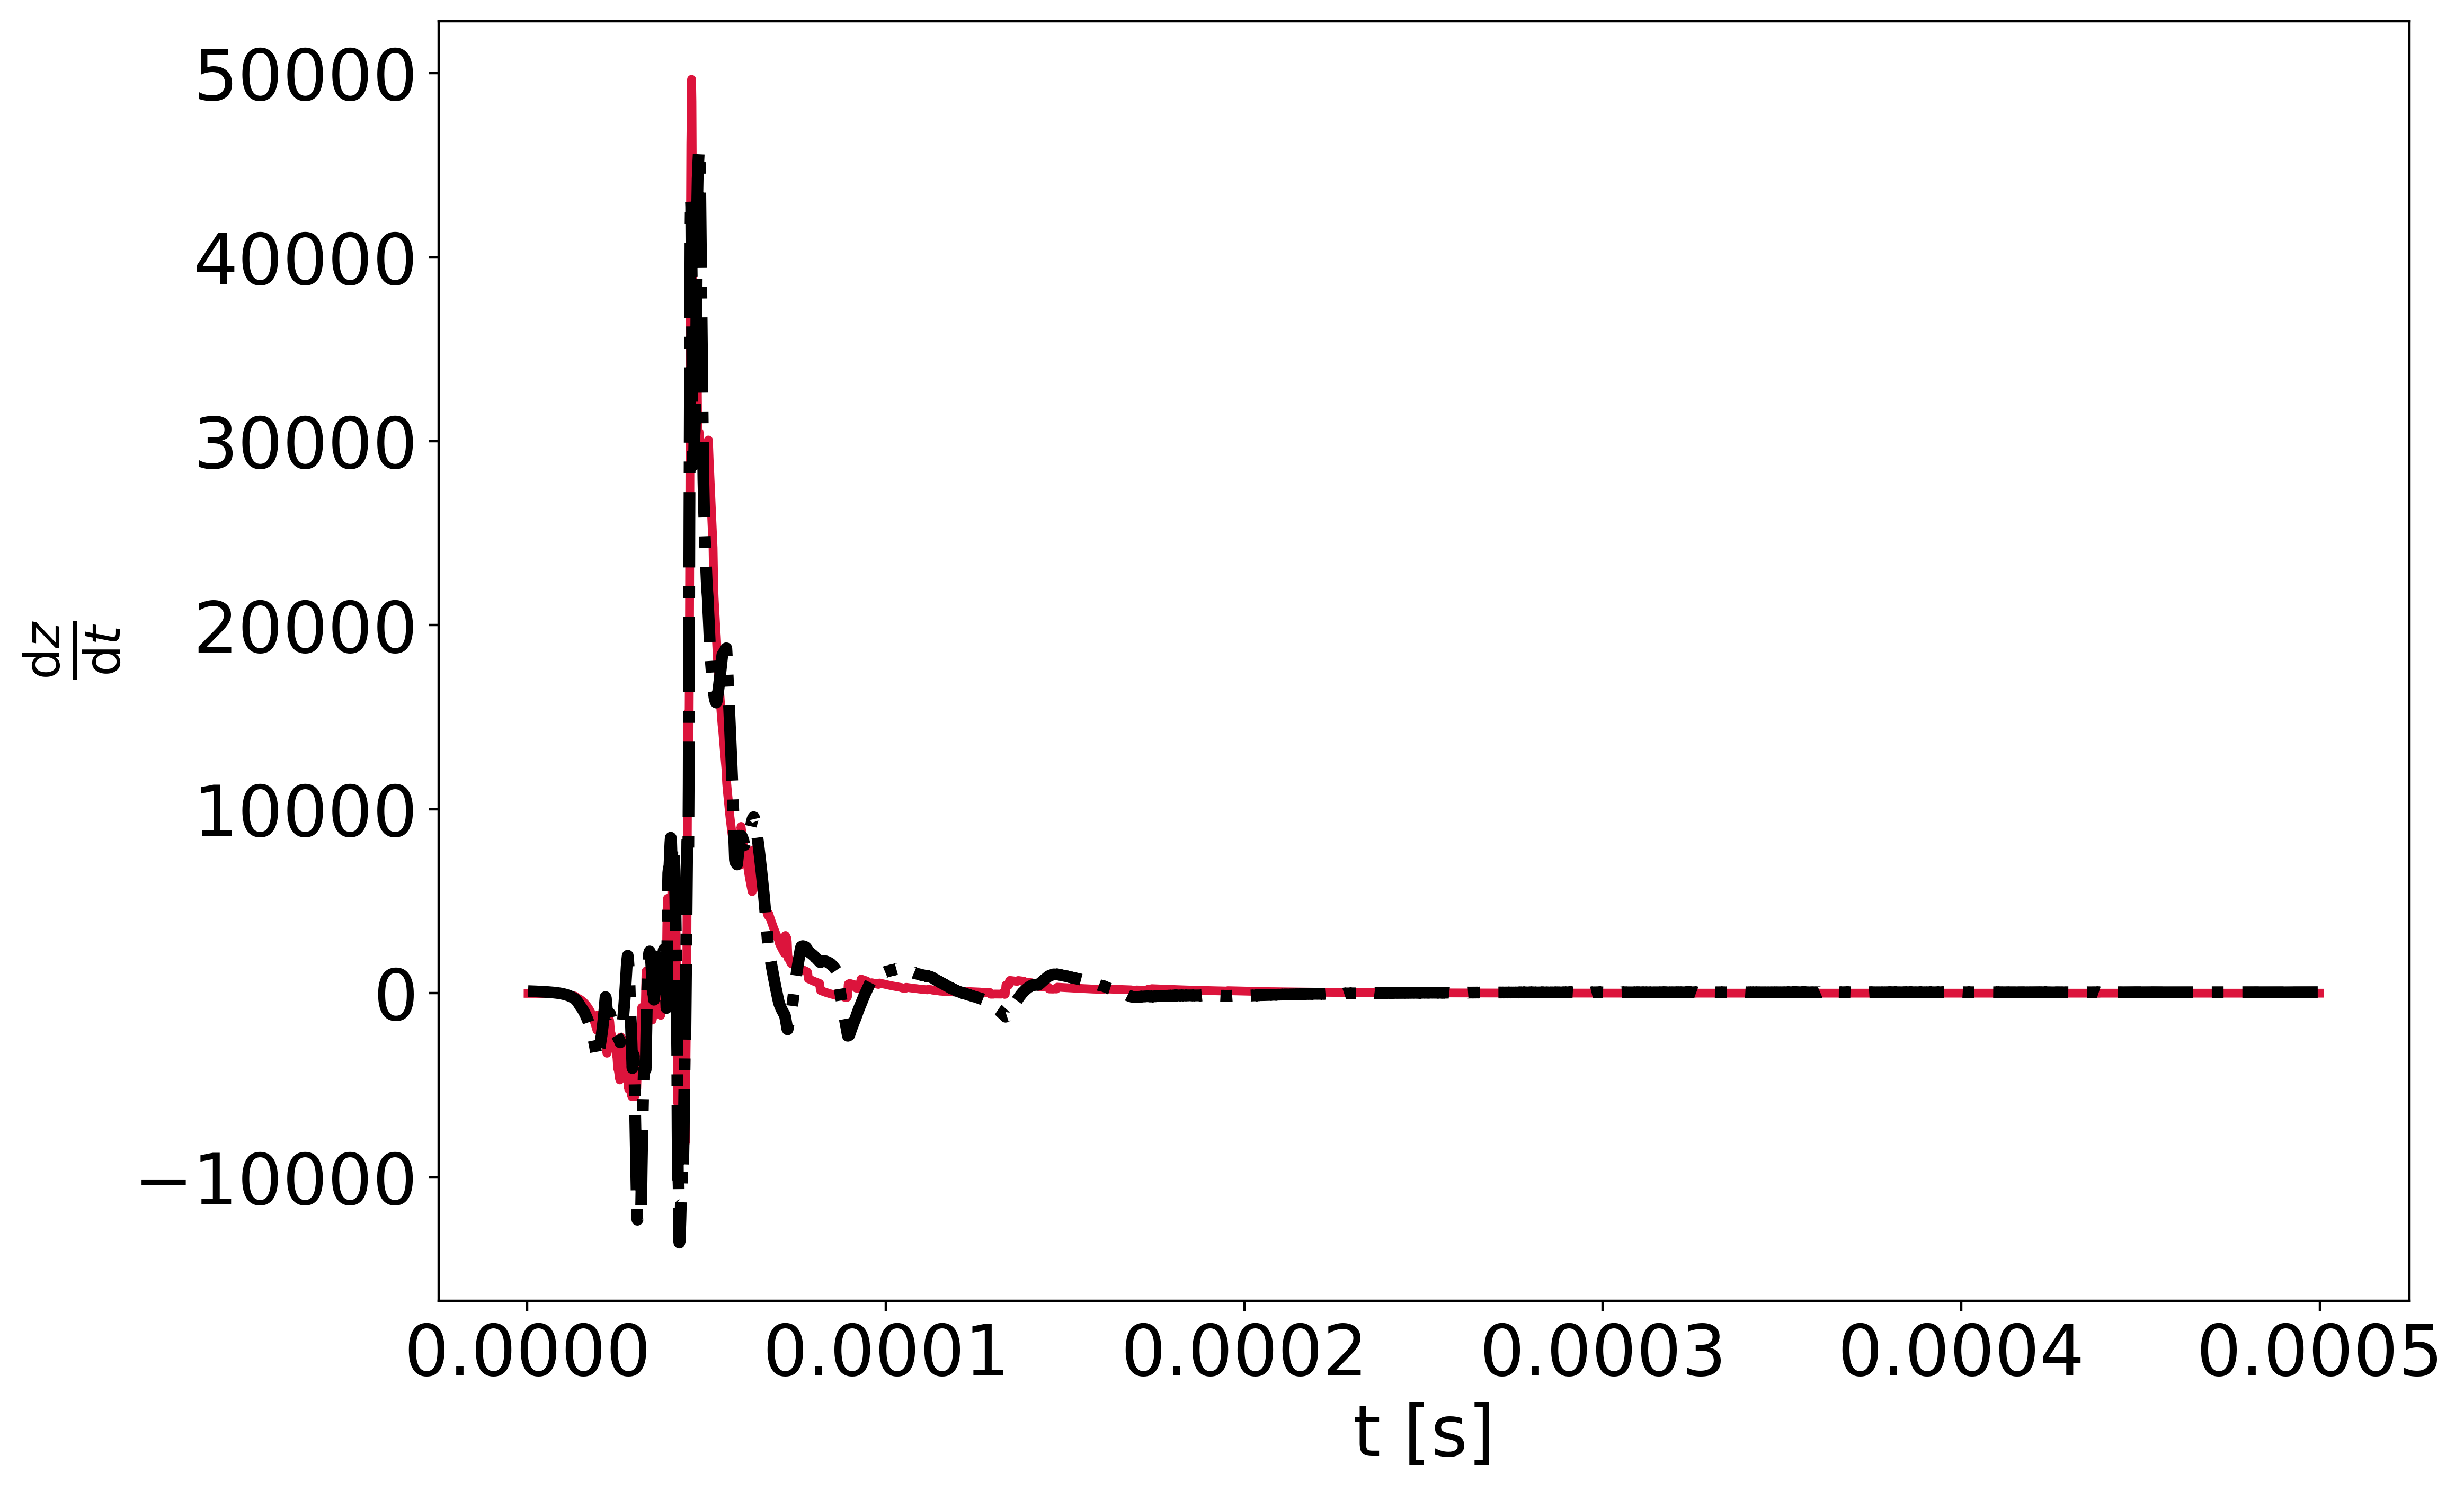

In [21]:
for k in range(np.shape(latent_space_check)[1]):
    
    prediction=np.matmul(check_inputs,np.transpose(coefficients[k,:]))+intercepts[k]
    
    #label=out_columns[k]
    #transformation_index=maximum_values.columns.get_loc(label)
    
    original=Z_gradient[:,k]#*maximum_values.iloc[0,transformation_index]
    #reconstruction=prediction*maximum_values.iloc[0,transformation_index]
    
    
    plt.figure(k, figsize=(12,8),dpi=400)
    plt.plot(time_data,original, color='crimson',label='Zgradient', linewidth=3)
    plt.plot(time_data,prediction,label='Reconstruction',color='k', linewidth=4,linestyle='dashdot')
    plt.xticks(fontsize=24)
    plt.yticks(fontsize=24)
    plt.xlabel('t [s]', fontsize=24)
    plt.ylabel(r' $\frac{\mathrm{d}z}{\mathrm{d}t}$', fontsize=24)
    plt.savefig('Z_gradients'+str(k)+'.jpg',dpi=400)
    #plt.legend()

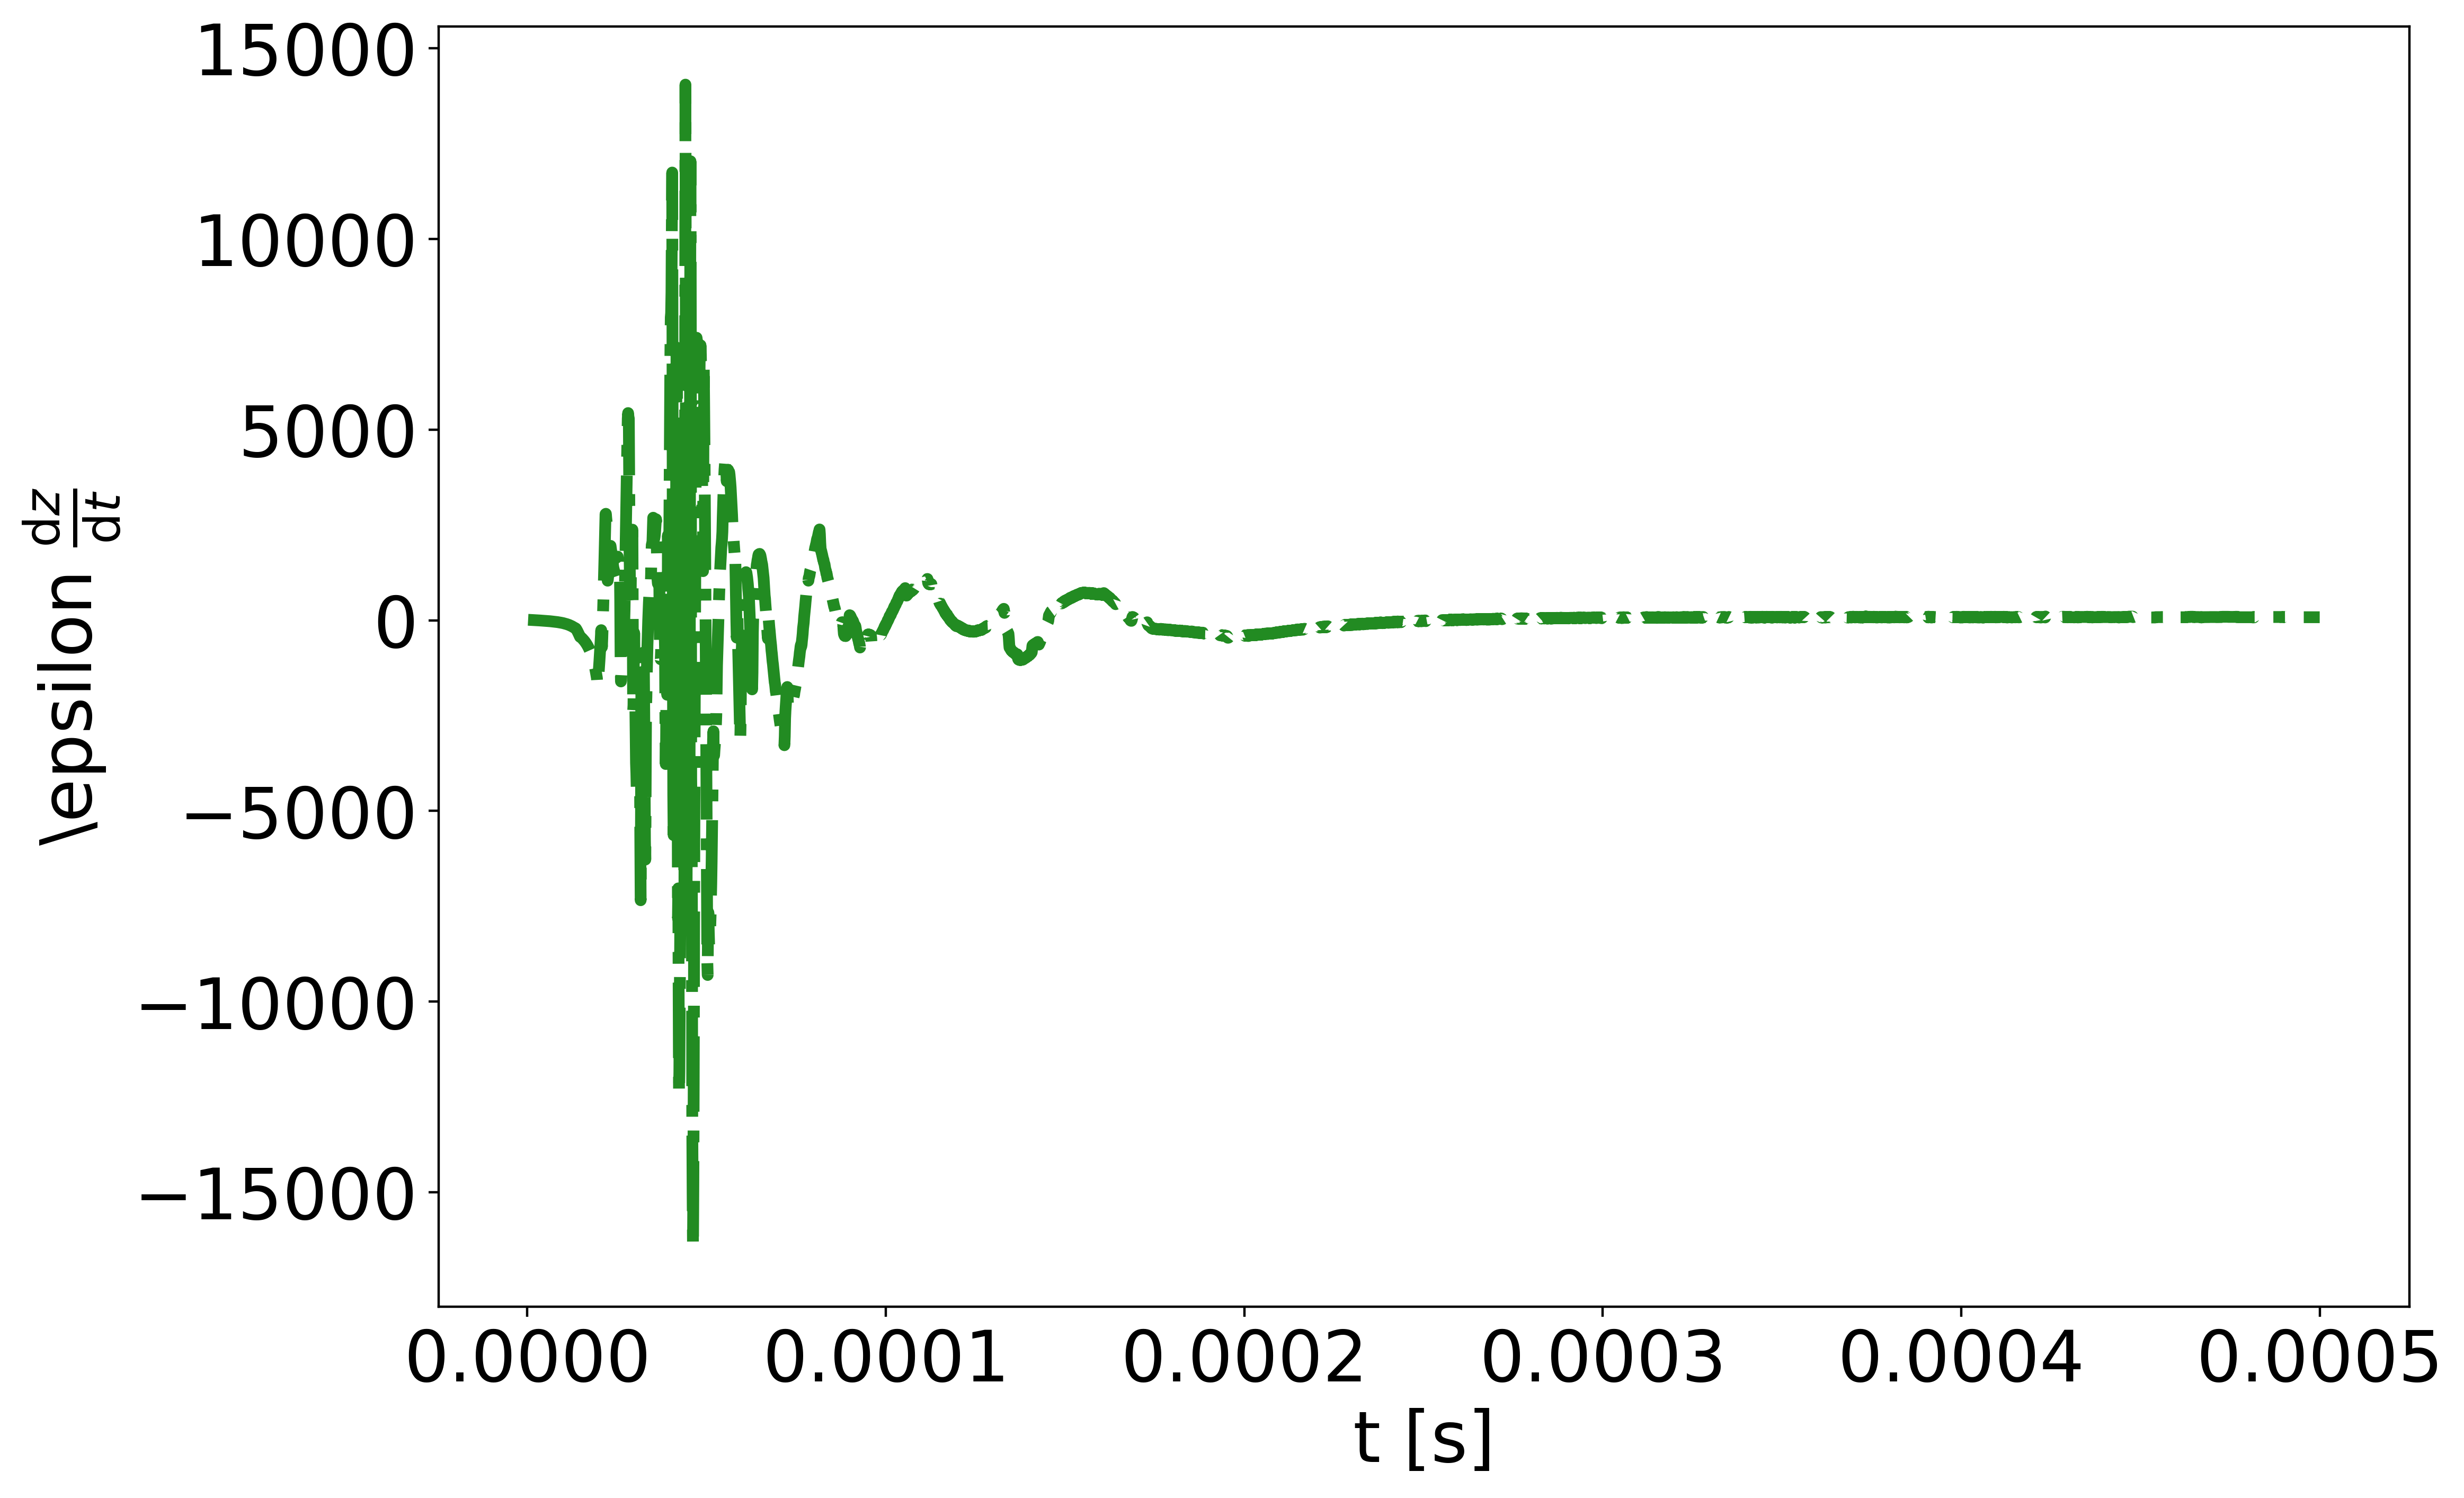

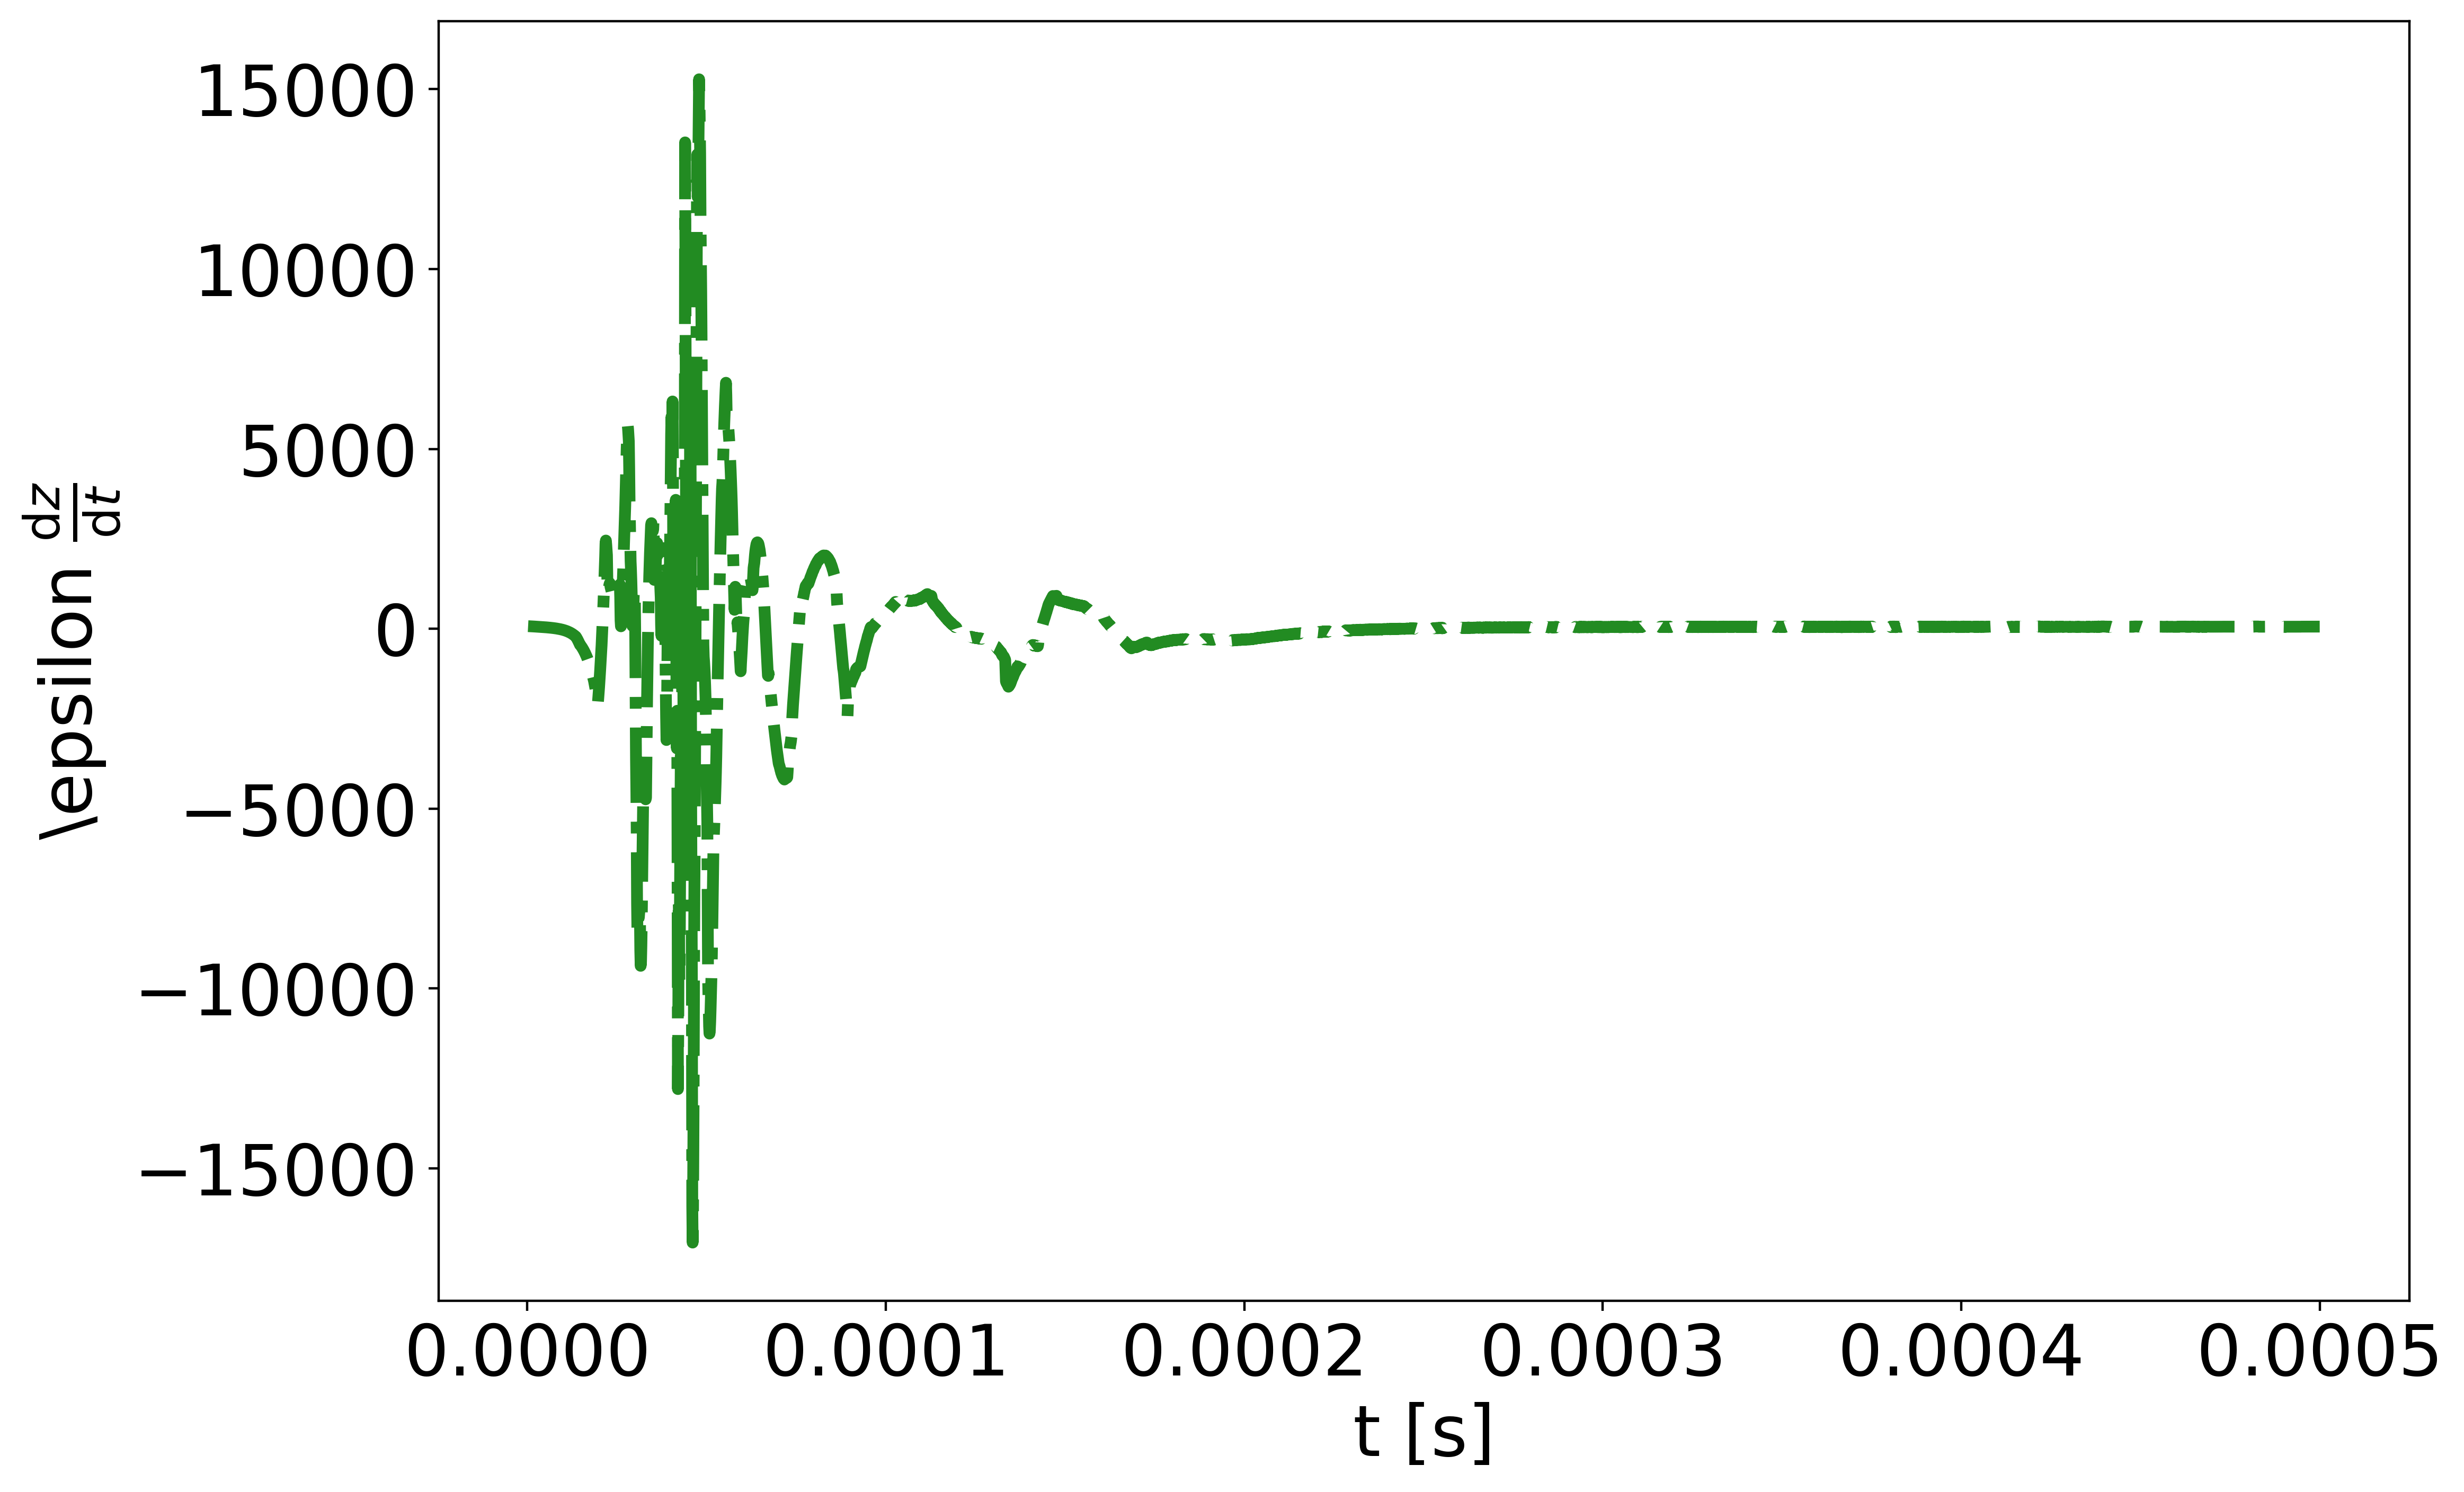

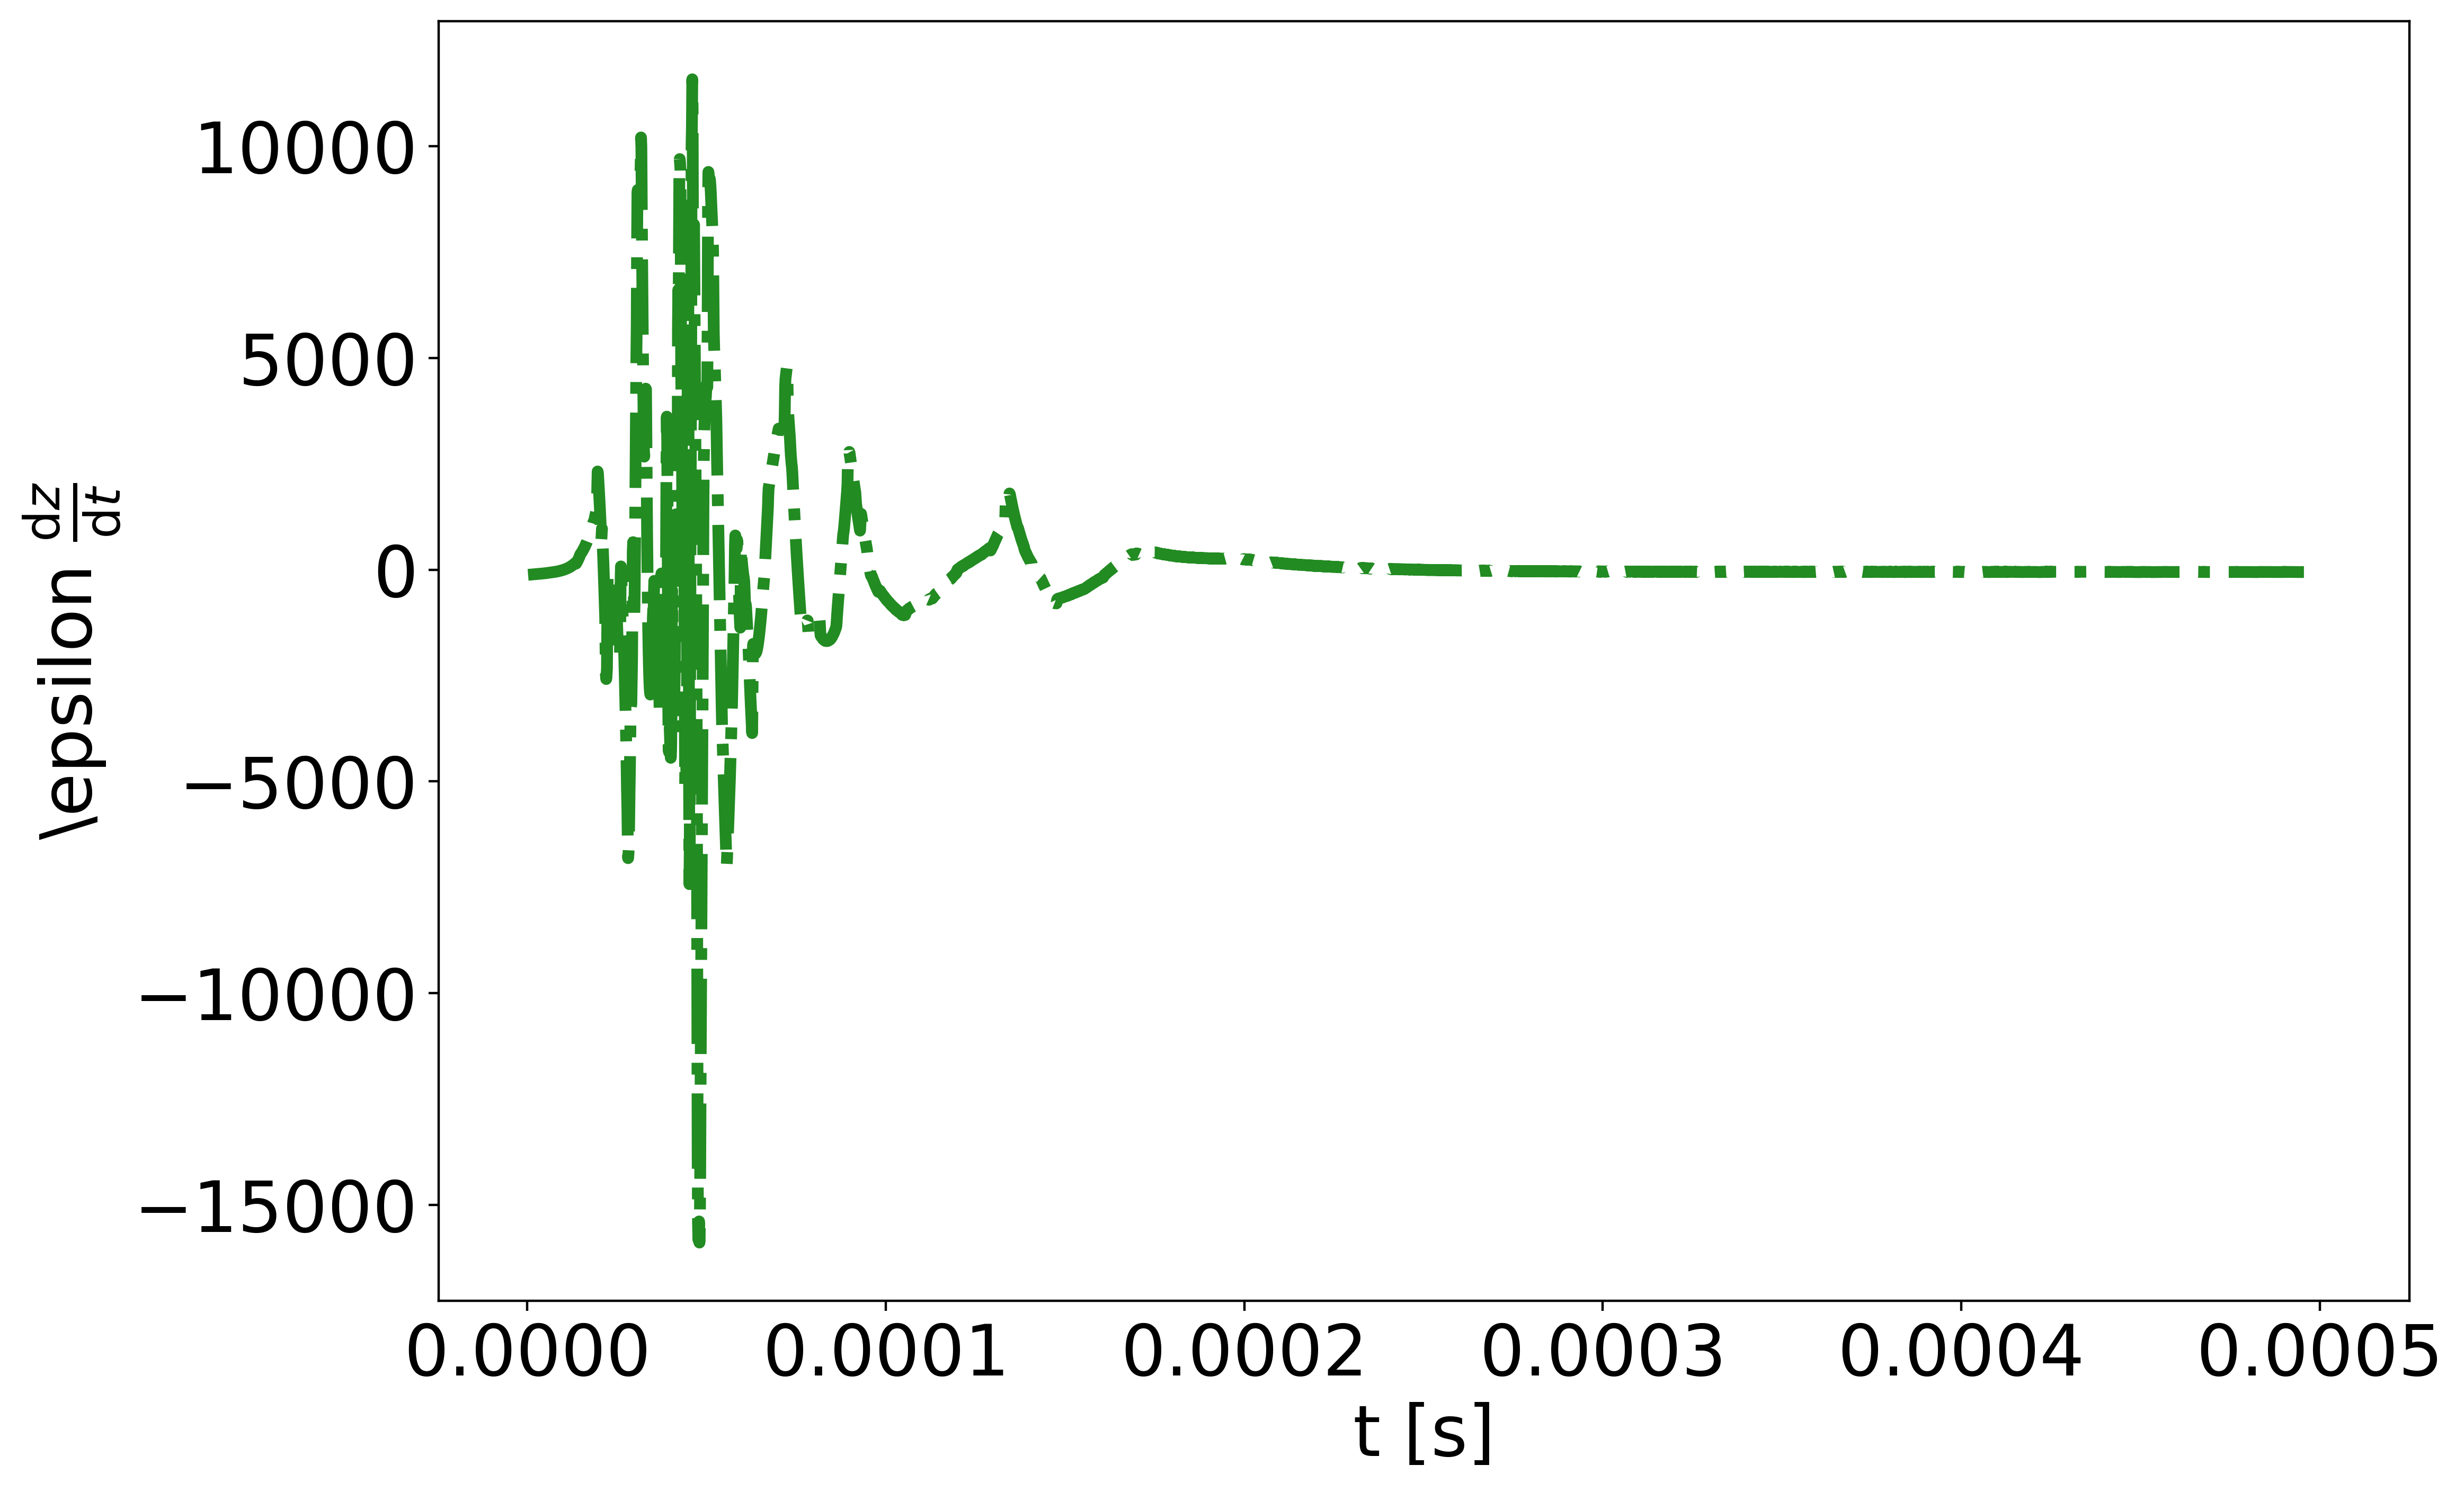

In [22]:
for k in range(np.shape(latent_space_check)[1]):
    
    prediction=np.matmul(check_inputs,np.transpose(coefficients[k,:]))+intercepts[k]
    
    #label=out_columns[k]
    #transformation_index=maximum_values.columns.get_loc(label)
    
    original=Z_gradient[:,k]#*maximum_values.iloc[0,transformation_index]
    #reconstruction=prediction*maximum_values.iloc[0,transformation_index]
    error=original-prediction
    
    plt.figure(k,figsize=(12,8),dpi=400)
    #plt.plot(time_data,original, label='Zgradient', linewidth=3)
    plt.plot(time_data,error,label='Reconstruction error', linewidth=4, color='forestgreen',linestyle='dashdot')
    plt.xlabel('t[s]')
    plt.xticks(fontsize=24)
    plt.yticks(fontsize=24)
    plt.xlabel('t [s]', fontsize=24)
    plt.ylabel(r'\epsilon $\frac{\mathrm{d}z}{\mathrm{d}t} $', fontsize=24)
    plt.savefig('z_gradients_errors'+str(k)+'.jpg',dpi=400)
    #plt.legend()

In [23]:
coefficients2=pd.DataFrame(coefficients)
intercepts2=pd.DataFrame(intercepts)
matrix=pd.concat([coefficients2,intercepts2],axis=1)

_,S,_=np.linalg.svd(matrix)

big_eigenvalue=S.max()
small_eigenvalue=S.min()

stiffness=big_eigenvalue/small_eigenvalue
print('stiffness',stiffness)

stiffness 9.115127364196416
